## 라이브러리 호출

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용하는 라이브러리
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import namedtuple # 튜플의 성질을 갖고 있는 자료형이지만 인덱스뿐만 아니라 키 값으로 데이터에 접근할 수 있음.
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 이미지 데이터 전처리

In [2]:
class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase):
    return self.data_transform[phase](img)

## 변수에 대한 값 정의

In [3]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [4]:
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

# 이미지가 저장된 폴더 경로를 지정합니다. 해당 경로는 Google Drive 내에 있는 폴더여야 합니다.
base_folder_path = '/content/drive/MyDrive/파이썬 기반 딥러닝학습/Data/train'

non_demented_folder = 'NonDemented'
verymild_demented_folder = 'VeryMildDemented'
mild_demented_folder = 'MildDemented'
moderate_demented_folder = 'ModerateDemented'

non_demented_image_filepaths = [os.path.join(base_folder_path, non_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, non_demented_folder))]
verymild_demented_image_filepaths = [os.path.join(base_folder_path, verymild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, verymild_demented_folder))]
mild_demented_image_filepaths = [os.path.join(base_folder_path, mild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, mild_demented_folder))]
moderate_demented_image_filepaths = [os.path.join(base_folder_path, moderate_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, moderate_demented_folder))]

# 모든 이미지 파일 경로를 하나의 리스트로 합칩니다.
images_filepaths = [*non_demented_image_filepaths, *verymild_demented_image_filepaths, *mild_demented_image_filepaths, *moderate_demented_image_filepaths]

# 이미지 파일을 읽어올 때 유효한 이미지 파일인지 확인합니다.
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

Mounted at /content/drive


## 데이터셋을 훈련, 검증 용도로 분리

In [5]:
len(correct_images_filepaths) # train 데이터셋 파일 갯수.

5121

In [6]:
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:3585] # 0.7% -> train
val_images_filepaths = correct_images_filepaths[3585:] # 0.3% -> validation
print(len(train_images_filepaths), len(val_images_filepaths))

3585 1536


## 이미지 데이터 확인

In [7]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

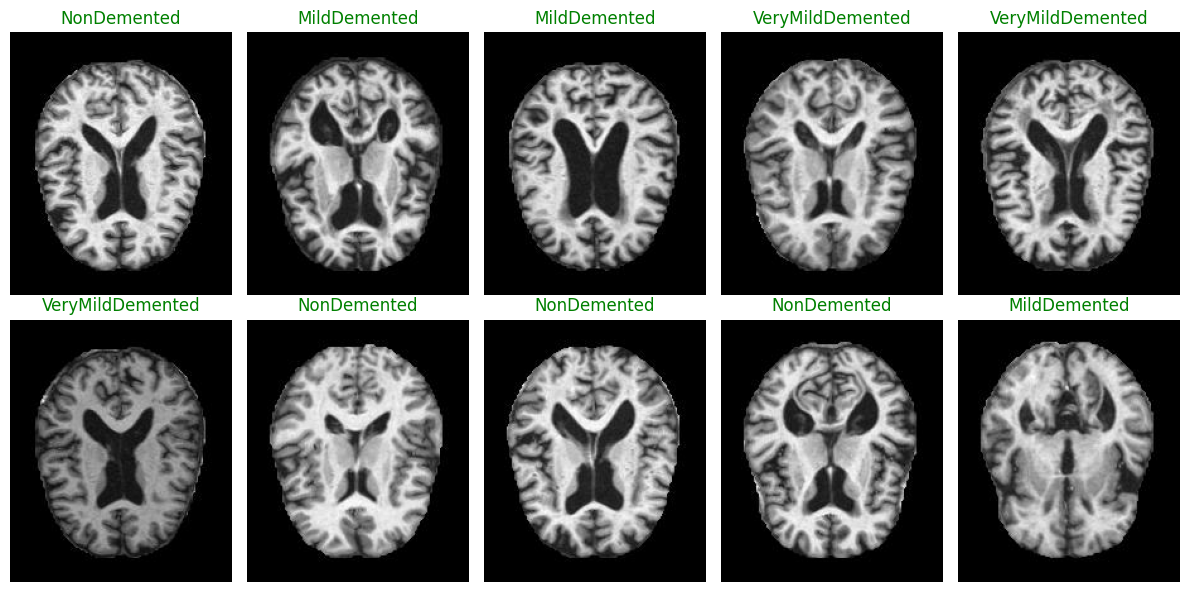

In [8]:
# %matplotlib inline

display_image_grid(val_images_filepaths[:10])

## 이미지에 대한 레이블 구분

In [9]:
class alzheimerDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):

        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]

        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label.startswith('nonDem'):
            label = 0
        elif label.startswith('verymildDem'):
            label = 1
        elif label.startswith('mildDem'):
            label = 2
        elif label.startswith('moderateDem'):
            label = 3
        return img_transformed, label

## 이미지 데이터셋 정의

In [10]:
train_dataset = alzheimerDataset(train_images_filepaths,
                                 transform=ImageTransform(size, mean, std),
                                 phase='train')
val_dataset = alzheimerDataset(val_images_filepaths,
                              transform=ImageTransform(size, mean, std),
                              phase='val')

index = 0 # index 0의 이미지 크기와 레이블에 대한 출력
print(train_dataset.__getitem__(index)[0].size()) # 이미지는 컬러(채널 3) 상태에서 224 * 224 크기를 갖고 있음.
print(train_dataset.__getitem__(index)[1]) # 0을 의미하기에 Non Demented

torch.Size([3, 224, 224])
0


## 데이터셋의 데이터를 메모리로 불러오기

In [11]:
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([2, 1, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 2, 1, 0, 0, 0, 0, 3, 1, 1, 0, 1, 0,
        1, 2, 0, 1, 1, 2, 0, 0])


## 기본 블록 정의

In [12]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False) # 3 x 3 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False) # 3 x 3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample: # 다운 샘플이 적용되는 부분.
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                            stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)

        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

## 병목 블록 정의

In [13]:
class Bottlenect(nn.Module):
    expansion = 4 # ResNet에서 병목 블록을 정의하기 위한 하이퍼 파라미터.

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                              stride=1, bias=False) # 1 x 1 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False) # 3 x 3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion*out_channels,
                              kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1,
                            stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion*out_channels)
            downsample = nn.Sequential(conv, bn)

        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)
        return x

## ResNet 모델 네트워크

In [14]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2,
                              padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottlenect):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def get_resnet_layer(self, block, n_blocks, channels, stride=1):
        layers = []
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))
        for i in range(1, n_blocks):
            layers.append(block(block.expansion*channels, channels))

        self.in_channels = block.expansion * channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h

## ResNetConfig 정의

In [15]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

## 기본 블록을 사용하여 ResNetConfig 정의

In [16]:
resnet18_config = ResNetConfig(block=BasicBlock,
                              n_blocks=[2, 2, 2, 2],
                              channels=[64, 128, 256, 512])

resnet34_config = ResNetConfig(block=BasicBlock,
                              n_blocks=[3, 4, 6, 3],
                              channels=[64, 128, 256, 512])

## 병목 블록을 사용하여 ResNetConfig 정의

In [17]:
resnet50_config = ResNetConfig(block=Bottlenect,
                              n_blocks=[3, 4, 6, 3],
                              channels=[64, 128, 256, 512])

resnet101_config = ResNetConfig(block=Bottlenect,
                              n_blocks=[3, 4, 23, 3],
                              channels=[64, 128, 256, 512])

resnet152_config = ResNetConfig(block=Bottlenect,
                              n_blocks=[3, 8, 36, 3],
                              channels=[64, 128, 256, 512])

## 사전 훈련된 ResNet 모델 사용

In [40]:
pretrained_model = models.resnet34(weights="ResNet34_Weights.DEFAULT")

## 사전 훈련된 ResNet 네트워크 확인

In [41]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## ResNet34 Config를 사용한 ResNet 모델 사용

In [42]:
OUTPUT_DIM = 4
model = ResNet(resnet34_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

## 옵티마이저와 손실 함수 정의

In [43]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

## 모델 학습 정확도 측정 함수 정의

In [44]:
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size

    return acc_1, acc_k

## 모델 학습 함수 정의

In [45]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred[0], y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

## 모델 평가 함수 정의

In [46]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0], y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

## 모델 학습 시간 측정 함수 정의

In [47]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))

    return elapsed_mins, elapsed_secs

## 모델 학습

In [48]:
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer,
                                                criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion,
                                                   device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/ResNet18-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
         f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
         f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 1.336 | Train Acc @1:  38.36% | Train Acc @5:  74.34%
	Valid Loss: 1.339 | Valid Acc @1:  37.11% | Valid Acc @5:  72.66%
Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 1.323 | Train Acc @1:  42.01% | Train Acc @5:  78.62%
	Valid Loss: 1.323 | Valid Acc @1:  39.26% | Valid Acc @5:  77.54%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.310 | Train Acc @1:  44.25% | Train Acc @5:  80.48%
	Valid Loss: 1.307 | Valid Acc @1:  42.12% | Valid Acc @5:  80.73%
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.298 | Train Acc @1:  44.83% | Train Acc @5:  82.55%
	Valid Loss: 1.299 | Valid Acc @1:  42.58% | Valid Acc @5:  81.38%
Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 1.288 | Train Acc @1:  45.55% | Train Acc @5:  83.41%
	Valid Loss: 1.290 | Valid Acc @1:  43.62% | Valid Acc @5:  82.88%
Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 1.274 | Train Acc @1:  47.32% | Train Acc @5:  83.85%
	Valid Loss: 1.277 | Valid Acc @1:  44.60% | Valid Acc @5:  83.59%
Epoch: 07 